In [299]:
import numpy as np
import pandas as pd
from matplotlib import font_manager, rc
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# matplotlib option
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# matplotlib font
font_name = font_manager.FontProperties(
    fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# matplotlib.rcParams['axes.unicode_minus'] = False
sns.set(font=font_name,
        rc={'axes.unicode_minus': False})  # to show negative sign on graphs

# pandas option
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option("display.precision", 2)


def drop_cols(df, cols):
    return df.drop(cols, axis=1)

def merge(df1, df2):
    return pd.merge(df1, df2, how='left', on=['시도명', '시군구명'])



In [300]:
df = pd.read_csv('./data/df_final_20220414.csv')

In [301]:
df.columns

Index(['고객번호', '성별구분', '나이', '직업위험등급', '직업대분류코드', '배우자여부', '자녀여부', '시도명',
       '시군구명', '월납보험료', '보험계약건수', '산출보험금', '보험금지급횟수', '최근보험료지급일수',
       '커피전문점/카페/다방(개수)', '실내골프연습장(개수)', '비만/피부관리(개수)', '장의사/관련서비스-종합(개수)',
       '학원-어린이영어(개수)', '어린이집(개수)', '2020_당해년 총인구<br>(A) (명)', '2020_건강생활실천율',
       '2021_고령인구비율', '2020_출생률', '경제활동참가율'],
      dtype='object')

In [302]:
cols = ['커피전문점/카페/다방(개수)', '실내골프연습장(개수)', '비만/피부관리(개수)', '장의사/관련서비스-종합(개수)',
        '학원-어린이영어(개수)', '어린이집(개수)']
df = drop_cols(df, cols)


In [303]:
df['산출보험금'].describe()
# outlier 확인이 필요하다

count    5.62e+05
mean     3.52e+04
std      4.04e+05
min     -3.64e+04
25%      0.00e+00
50%      0.00e+00
75%      0.00e+00
max      6.68e+07
Name: 산출보험금, dtype: float64

In [304]:
df['산출보험금'].sort_values()

389050   -3.64e+04
117450   -8.04e+03
0         0.00e+00
370072    0.00e+00
370071    0.00e+00
            ...   
90049     4.85e+07
383538    5.51e+07
94867     6.25e+07
369726    6.41e+07
562209    6.68e+07
Name: 산출보험금, Length: 562426, dtype: float64

##### 언더샘플링

In [305]:
# 보험금지급횟수 0인 값은 제외하고 clustering을 진행하는 것이 나을까?
# ACTION: 보험금지급횟수 0인 값을 언더샘플링
claim_yes = df.loc[df['보험금지급횟수'] != 0].copy()
claim_no = df.loc[df['보험금지급횟수'] == 0].copy()


In [306]:
claim_no.shape

(533808, 19)

In [307]:
claim_yes.shape

(28618, 19)

In [308]:
claim_yes.shape[0] / 4

7154.5

In [309]:
claim_no.shape[0] / 7154.5


74.61150324970298

In [310]:
1/74.61150324970298


0.01340275904445044

In [311]:
df.shape

(562426, 19)

In [312]:
# 0.01340275904445044 비율로 resampling
claim_no = claim_no.sample(frac=0.01340275904445044, random_state=13)
claim_no.shape

(7155, 19)

In [313]:
df = pd.concat([claim_no, claim_yes], ignore_index=True)
df.shape

(35773, 19)

##### 상권 데이터

In [315]:
# 상권별가게수를 인구수로 나눈다 -> 인구대비상권별가게수
population = df[['시도명', '시군구명', '2020_당해년 총인구<br>(A) (명)']]
population = population.drop_duplicates()

def func1(store, population=population):
    store = pd.merge(store, population, how='left', on=['시도명', '시군구명'])
    store['업종별개수'] = store['업종별개수'] / \
        store['2020_당해년 총인구<br>(A) (명)']
    store = store.drop('2020_당해년 총인구<br>(A) (명)', axis=1)
    return store

store_medium = pd.read_csv('./data/processed/store_medium.csv', encoding='cp949')

store_medium = func1(store_medium)

store_medium = store_medium.pivot_table(index=['시도명', '시군구명'], columns='상권업종중분류명',
                                      aggfunc='sum').reset_index()
store_medium.columns = store_medium.columns.droplevel()
store_medium.columns = ['시도명', '시군구명', *store_medium.columns[2:]]


In [316]:
store_medium.to_csv('./data/store_medium.csv', encoding='cp949')


In [317]:
def func2(df1, df2):
    return pd.merge(df1, df2, how='left', on=['시도명', '시군구명'])

df = func2(df, store_medium)

In [318]:
df.to_csv('./data/df_medium.csv', index=False)

##### 스케일링 적용

In [319]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df[['산출보험금']] = scaler.fit_transform(df[['산출보험금']])
df.to_csv('./data/df_medium_scaled.csv', index=False)


In [320]:
# 미추홀구가 남구로 반영이 잘 안 되었음; 추후 반영 필요함

In [321]:
# 미추홀구 drop
idx = df.loc[df['2020_출생률'].isnull()].index
temp = df.copy()
temp = temp.drop(idx, axis=0)
# 결측치 0으로 채우기
temp = temp.fillna(0)

In [322]:
x = temp.select_dtypes(include=np.number)
x = x.drop(['고객번호', '산출보험금', '보험금지급횟수', '최근보험료지급일수'], axis=1)
y = temp['산출보험금']


In [323]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=13)


In [324]:
import matplotlib.pyplot as plt
import seaborn as sns

my_predictions = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive',
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray',
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
          ]


def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()


def mse_eval(name_, pred, actual):
    global predictions
    global colors

    plot_predictions(name_, pred, actual)

    mse = mean_squared_error(pred, actual)
    my_predictions[name_] = mse

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)

    df = pd.DataFrame(y_value, columns=['model', 'mse'])
    print(df)
    min_ = df['mse'].min() - 10
    max_ = df['mse'].max() + 10

    length = len(df)

    plt.figure(figsize=(10, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=15)
    bars = ax.barh(np.arange(len(df)), df['mse'])

    for i, v in enumerate(df['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k',
                fontsize=15, fontweight='bold')

    plt.title('MSE Error', fontsize=18)
    plt.xlim(min_, max_)

    plt.show()


def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True


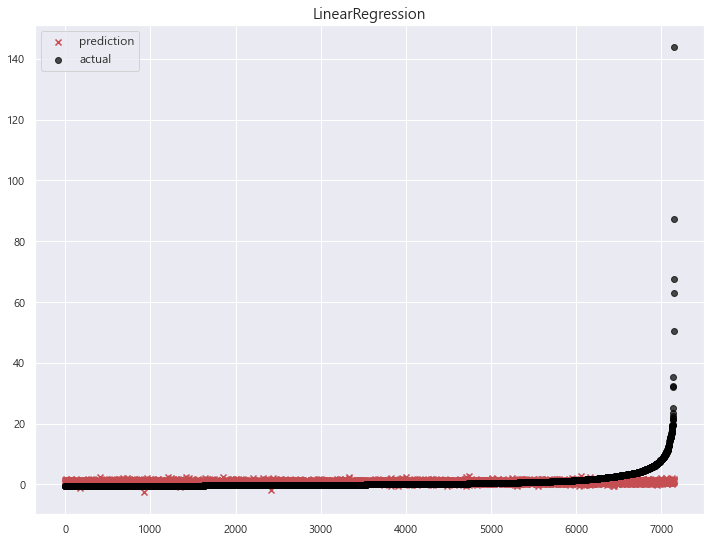

              model    mse
0  LinearRegression  10.69


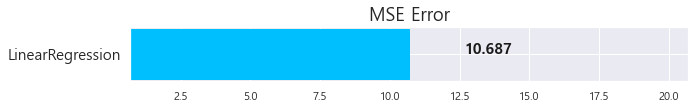

In [325]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1)
model.fit(x_train, y_train)
pred = model.predict(x_test)
mse_eval('LinearRegression', pred, y_test)


In [326]:
from sklearn.model_selection import cross_val_score
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(
    ridge, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE scores : ', np.round(avg_rmse, 2))


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.48311e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.18085e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.64574e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


5 folds의 개별 Negative MSE scores :  [ -7.71  -8.88  -8.62 -11.82 -15.39]
5 folds의 개별 RMSE scores :  [2.78 2.98 2.94 3.44 3.92]
5 folds의 평균 RMSE scores :  3.21


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.56673e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.81349e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [327]:
# 릿지에 사용될 alpha 파라미터 값
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 RMSE 계산
for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    # cross_val_score를 이용해 5fold의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(
        ridge, x_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('alpha {0} 일 때 5 폴드의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.8831e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.7019e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.03277e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.185e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.92738e-27): result may not be accurate.
  

alpha 0 일 때 5 폴드의 평균 RMSE : 3.216


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.19996e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.05298e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.62067e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.95999e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.44404e-18): result may not be accurate

alpha 0.1 일 때 5 폴드의 평균 RMSE : 3.211


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60766e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.52452e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.72621e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


alpha 1 일 때 5 폴드의 평균 RMSE : 3.211


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.48311e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.18085e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.64574e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.56673e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.81349e-17): result may not be accurate

alpha 10 일 때 5 폴드의 평균 RMSE : 3.211
alpha 100 일 때 5 폴드의 평균 RMSE : 3.211


C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.64411e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.34926e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.32227e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\joon9\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.36498e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


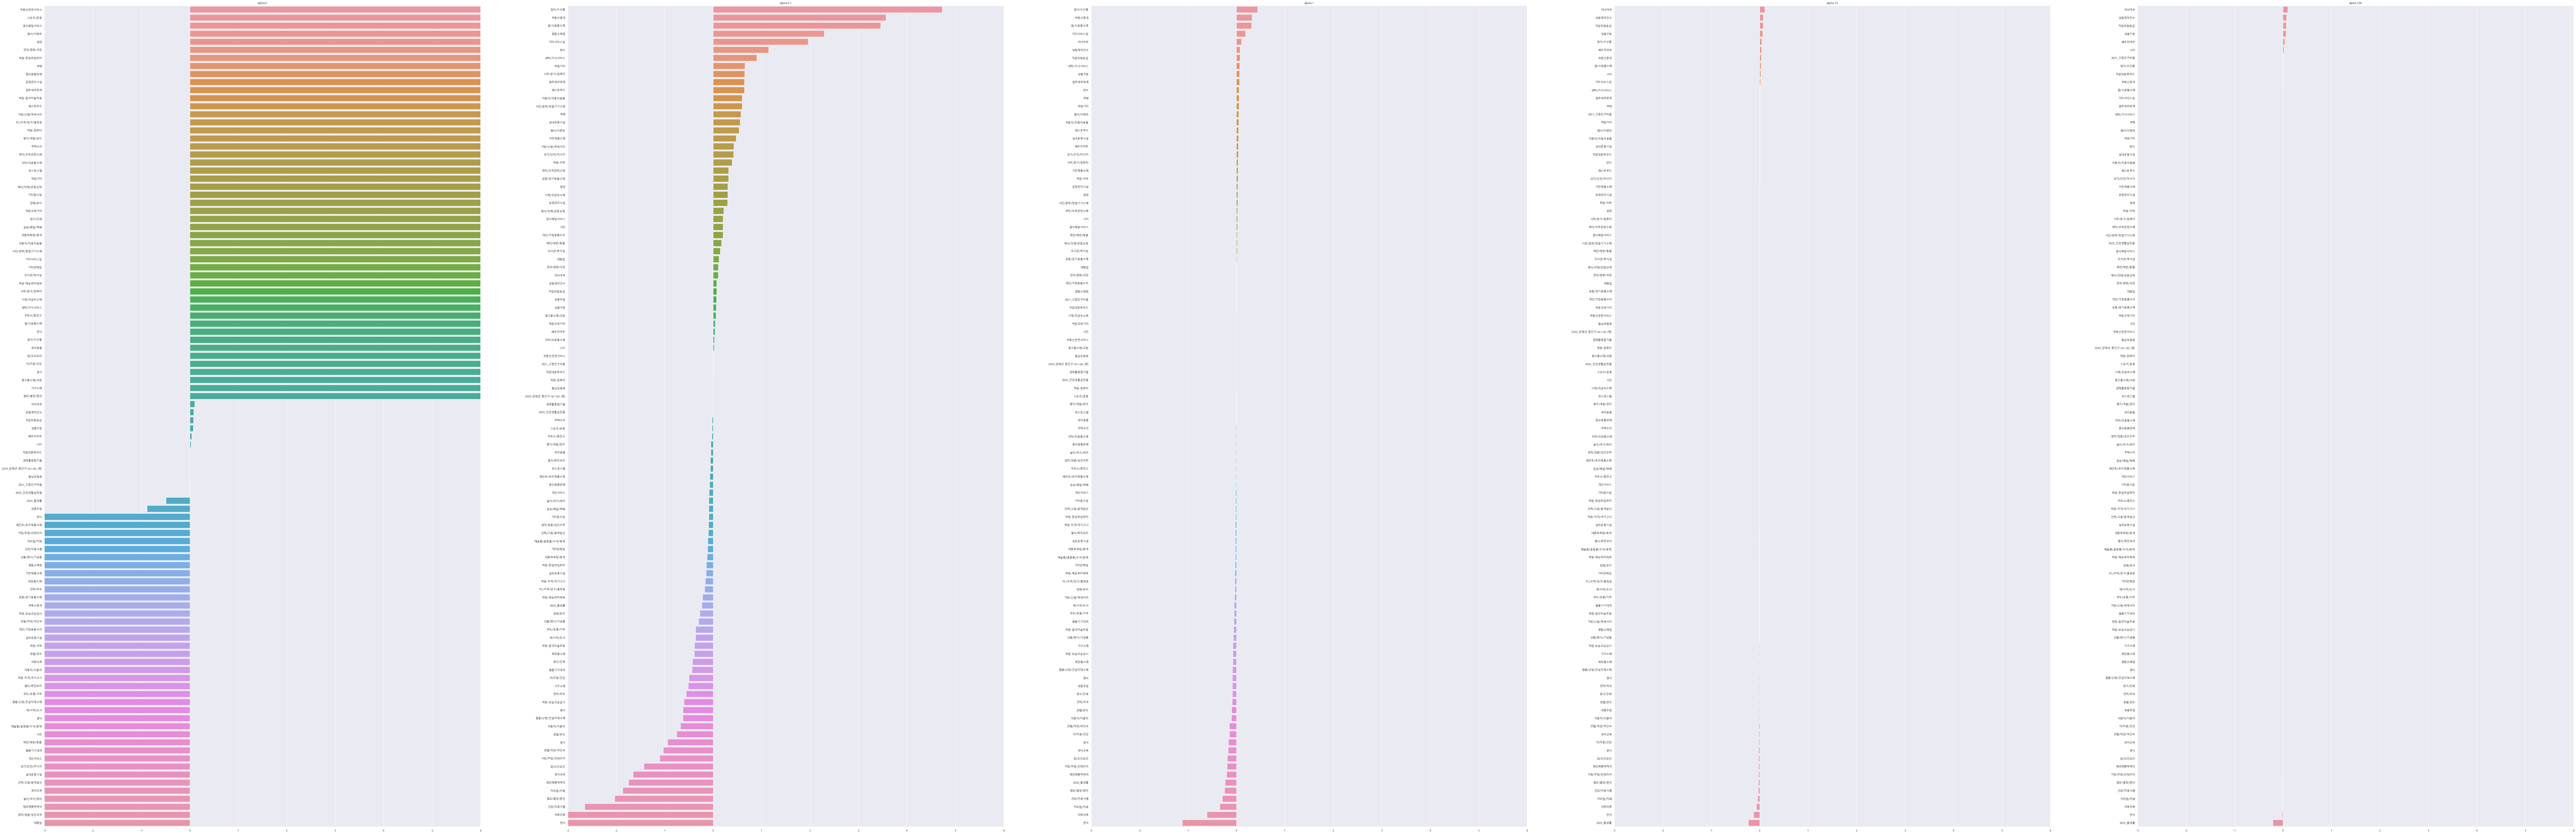

In [328]:
# 각 alhpa값에 따른 회귀 계수 값 시각화
fig, axes = plt.subplots(figsize=(180, 60), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DF
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화, pos는 axis의 위치
for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(x_train, y_train)

    # alhpa 값에 따른 피처별 회귀 계수를 Sereis로 변환하고 DF 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=x_train.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff

    # barplot으로 각 alhpa값에서의 회귀 계수를 시각화
    coeff = coeff.sort_values(ascending=False)
    axes[pos].set_title(colname)
    axes[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axes[pos])

plt.show()


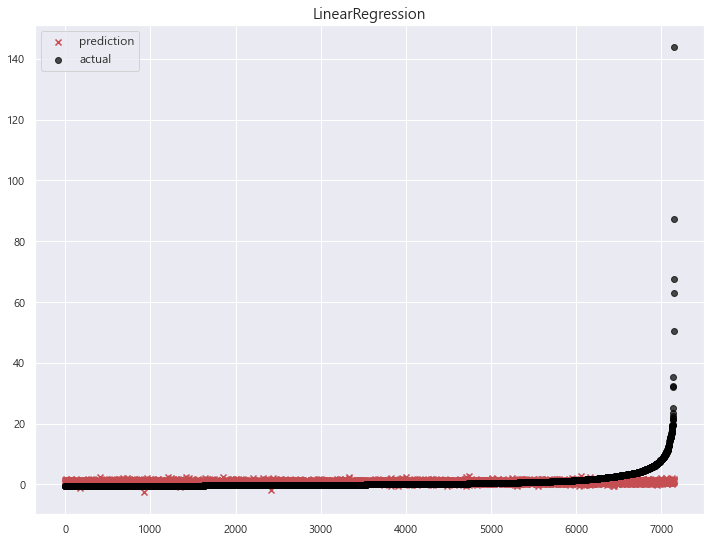

              model    mse
0  LinearRegression  10.69


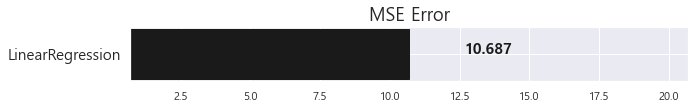

In [329]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=-1)
model.fit(x_train, y_train)
pred = model.predict(x_test)
mse_eval('LinearRegression', pred, y_test)


In [344]:
df = pd.read_csv('./data/df_medium.csv')

In [345]:
df['산출보험금'].value_counts(bins=100).sort_index()

(-103223.21500000001, 631678.14]    28533
(631678.14, 1299770.28]              3541
(1299770.28, 1967862.42]             1406
(1967862.42, 2635954.56]              816
(2635954.56, 3304046.7]               424
(3304046.7, 3972138.84]               271
(3972138.84, 4640230.98]              217
(4640230.98, 5308323.12]              137
(5308323.12, 5976415.26]               82
(5976415.26, 6644507.4]                64
(6644507.4, 7312599.54]                63
(7312599.54, 7980691.68]               46
(7980691.68, 8648783.82]               32
(8648783.82, 9316875.96]               27
(9316875.96, 9984968.1]                12
(9984968.1, 10653060.24]                9
(10653060.24, 11321152.38]             11
(11321152.38, 11989244.52]              8
(11989244.52, 12657336.66]              5
(12657336.66, 13325428.8]               6
(13325428.8, 13993520.94]               8
(13993520.94, 14661613.08]              4
(14661613.08, 15329705.22]              8
(15329705.22, 15997797.36]        

##### 원핫인코딩

In [77]:
# temp = pd.get_dummies(df_large, columns=['상권업종대분류명'])
# df_

In [22]:
sns.heatmap(claim_no)

ValueError: could not convert string to float: '부산광역시'

##### OneSidedSelection 언더샘플링

In [9]:
X_imb = df.drop(['보험금청구여부', '고객번호'], axis=1)
y_imb = df['보험금청구여부']


In [10]:
from imblearn.under_sampling import *
from imblearn.under_sampling import OneSidedSelection
X_samp, y_samp = OneSidedSelection(random_state=0).fit_sample(X_imb, y_imb)

plt.subplot(121)
classification_result2(X_imb, y_imb)
plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)


ModuleNotFoundError: No module named 'imblearn'

##### RFM segmentation

In [ ]:
df_large.shape

NameError: name 'df_large' is not defined

In [69]:
inertia_list = []
for num_clusters in range(1, 11):
    kmeans_model = KMeans(n_clusters=num_clusters, init="k-means++")
    kmeans_model.fit(X)
    inertia_list.append(kmeans_model.inertia_)


,성별구분,나이,직업위험등급,직업대분류코드,배우자여부,자녀여부,시도명,시군구명,월납보험료,보험계약건수,산출보험금,보험금지급횟수,최근보험료지급일수,2020_당해년 총인구<br>(A) (명),2020_건강생활실천율,2021_고령인구비율,2020_출생률,경제활동참가율,상권업종대분류명,상권업종대분류명개수
0,1,54,0,15,1,0,부산광역시,수영구,36770,1,0.0,0,0.0,178124.0,37.8,22.3,0.66,75.7,관광/여가/오락,168.0
1,1,54,0,15,1,0,부산광역시,수영구,36770,1,0.0,0,0.0,178124.0,37.8,22.3,0.66,75.7,부동산,344.0
2,1,54,0,15,1,0,부산광역시,수영구,36770,1,0.0,0,0.0,178124.0,37.8,22.3,0.66,75.7,생활서비스,1431.0
3,1,54,0,15,1,0,부산광역시,수영구,36770,1,0.0,0,0.0,178124.0,37.8,22.3,0.66,75.7,소매,2482.0
4,1,54,0,15,1,0,부산광역시,수영구,36770,1,0.0,0,0.0,178124.0,37.8,22.3,0.66,75.7,숙박,114.0


clustering

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300,random_state=0)
kmeans.fit(irisDF)
